In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms, models
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
import os
import csv

# Set the directory 
root_dir = 'Dataset\Dataset\Testing_data'  
output_csv = 'animal_images_test.csv' 

# List to hold all (image path, label) tuples
image_paths = []

# Walk through the directory and gather data
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  
            print(root)
            label = os.path.basename(root)  # Folder name as label
            path = os.path.join(root, file)  # Full path to the image
            image_paths.append((path, label))

# Write data to CSV
with open(output_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'label'])  # Header row
    for path, label in image_paths:
        writer.writerow([path, label])




Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data\badger
Dataset\Dataset\Testing_data

In [3]:
class AnimalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        # Convert label to torch.long
        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [20]:
# Parameters
num_classes = 6
batch_size = 16
learning_rate = 0.001
num_epochs = 25
image_size = 224
csv_file = 'animal_images.csv'  # Path to your CSV file

# Data transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Read CSV and prepare dataset
df = pd.read_csv('animal_images.csv')

# Convert labels to numerical values and ensure they are integers
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)
# Split the dataset
train_df, val_df = train_test_split(df, test_size=0.2)

# Create dataset objects
train_dataset = AnimalDataset(dataframe=train_df, transform=transform)
val_dataset = AnimalDataset(dataframe=val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [18]:
df['label']

0       0
1       0
2       0
3       0
4       0
       ..
5853    5
5854    5
5855    5
5856    5
5857    5
Name: label, Length: 5858, dtype: int64

In [21]:
# Load pre-trained ResNet model and modify it
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

C:\Users\user1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
print(torch.cuda.is_available())

False


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

import matplotlib.pyplot as plt

# Variables for precision and recall calculation
class_TP = list(0. for i in range(num_classes))  # True Positives
class_FP = list(0. for i in range(num_classes))  # False Positives
class_FN = list(0. for i in range(num_classes))  # False Negatives

# Variables to store metrics per epoch 
epoch_precision = {i: [] for i in range(num_classes)}
epoch_recall = {i: [] for i in range(num_classes)}
epoch_accuracy = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_id,  batch in enumerate(train_loader):
        images, labels  = batch

        # we put the data on the same device
        images , labels = images.to(device), labels.to(device)    # Move data to GPU
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_id % 10 == 0:
            print("epoch: {:03d}, batch: {:03d}, loss: {:.3f} ".format(epoch+1, batch_id+1, loss.item()))
    # Reset metrics for each epoch
    class_TP = [0] * num_classes
    class_FP = [0] * num_classes
    class_FN = [0] * num_classes
    total, correct = 0, 0

    # Validation with precision and recall calculation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(labels.size(0)):
                label = labels[i]
                pred_label = predicted[i]
                if label == pred_label:
                    class_TP[label] += 1
                else:
                    class_FP[pred_label] += 1
                    class_FN[label] += 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store metrics per class
    for i in range(num_classes):
        precision = 100 * class_TP[i] / (class_TP[i] + class_FP[i]) if (class_TP[i] + class_FP[i]) > 0 else 0
        recall = 100 * class_TP[i] / (class_TP[i] + class_FN[i]) if (class_TP[i] + class_FN[i]) > 0 else 0
        epoch_precision[i].append(precision)
        epoch_recall[i].append(recall)

    # Store overall accuracy
    accuracy = 100 * correct / total
    epoch_accuracy.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}%')

epoch: 001, batch: 001, loss: 0.964 
epoch: 001, batch: 011, loss: 0.805 
epoch: 001, batch: 021, loss: 0.745 
epoch: 001, batch: 031, loss: 0.905 
epoch: 001, batch: 041, loss: 0.710 
epoch: 001, batch: 051, loss: 0.915 
epoch: 001, batch: 061, loss: 0.723 
epoch: 001, batch: 071, loss: 0.822 
epoch: 001, batch: 081, loss: 0.724 
epoch: 001, batch: 091, loss: 0.983 
epoch: 001, batch: 101, loss: 0.683 
epoch: 001, batch: 111, loss: 0.607 
epoch: 001, batch: 121, loss: 0.885 
epoch: 001, batch: 131, loss: 0.757 
epoch: 001, batch: 141, loss: 0.653 
Epoch [1/10], Accuracy: 64.84641638225256%
epoch: 002, batch: 001, loss: 0.996 
epoch: 002, batch: 011, loss: 0.445 
epoch: 002, batch: 021, loss: 0.862 
epoch: 002, batch: 031, loss: 0.413 
epoch: 002, batch: 041, loss: 0.332 
epoch: 002, batch: 051, loss: 0.803 
epoch: 002, batch: 061, loss: 0.656 
epoch: 002, batch: 071, loss: 0.751 
epoch: 002, batch: 081, loss: 0.930 
epoch: 002, batch: 091, loss: 0.651 
epoch: 002, batch: 101, loss: 0.

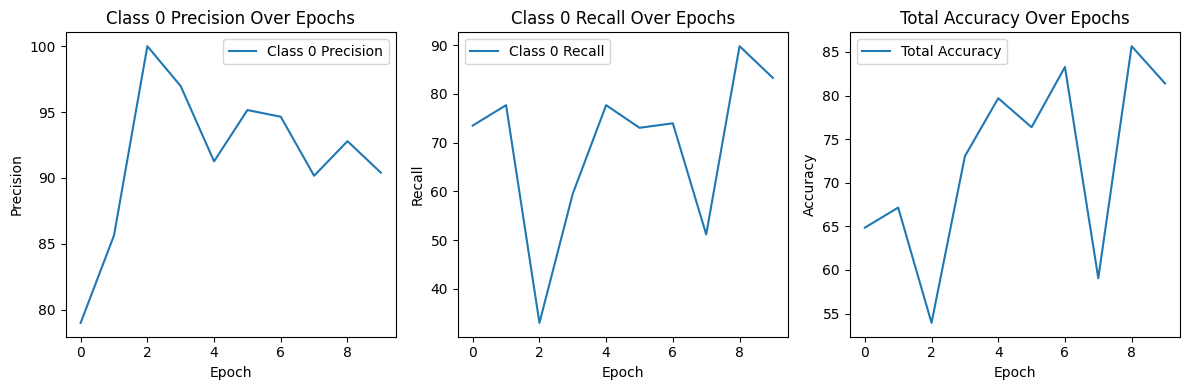

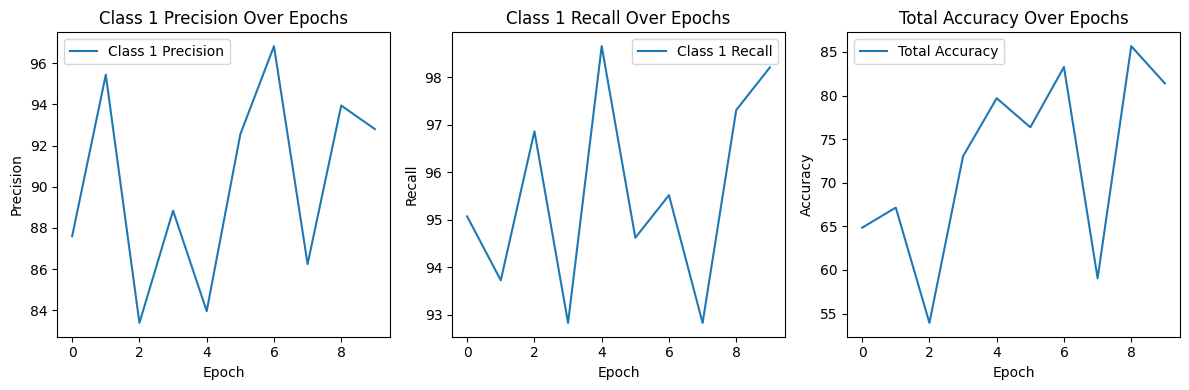

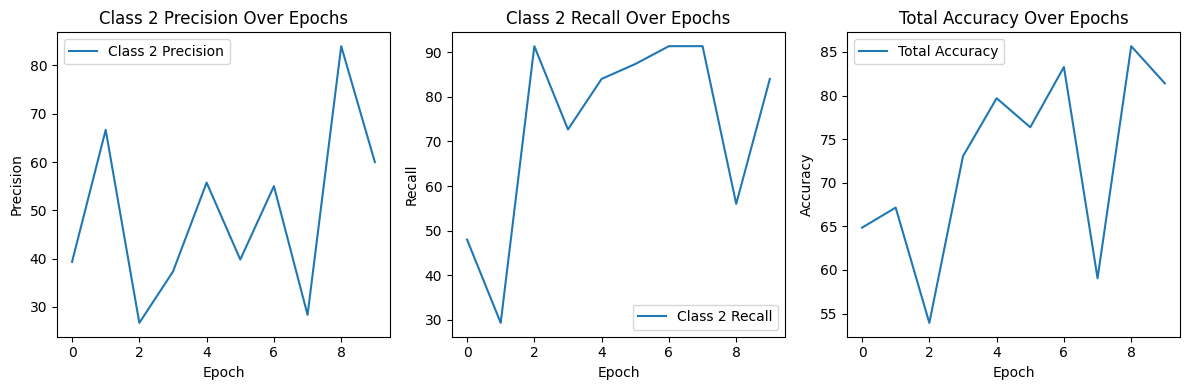

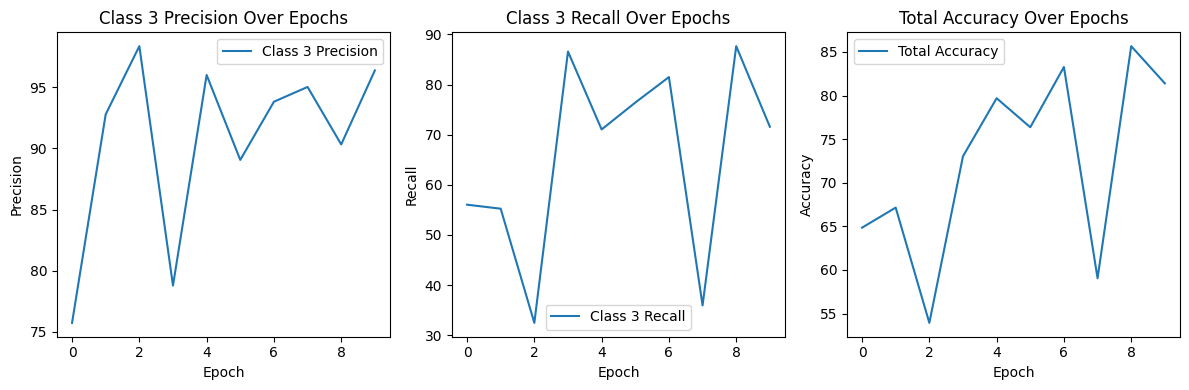

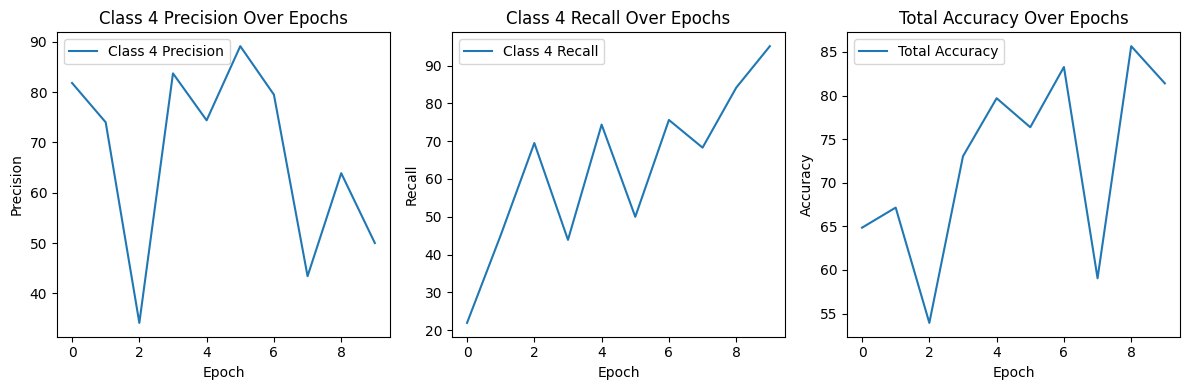

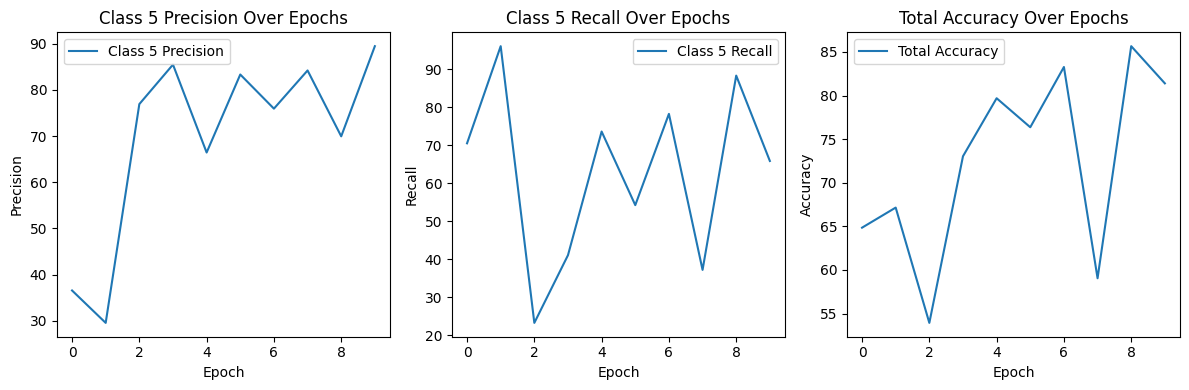

In [17]:
# Plotting the metrics evolution
for i in range(num_classes):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epoch_precision[i], label=f'Class {i} Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title(f'Class {i} Precision Over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epoch_recall[i], label=f'Class {i} Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title(f'Class {i} Recall Over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epoch_accuracy, label='Total Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Total Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
# Save the model
torch.save(model.state_dict(), 'animal_classifier_model.pth')

## 20 epochs

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

import matplotlib.pyplot as plt

# Variables for precision and recall calculation
class_TP = list(0. for i in range(num_classes))  # True Positives
class_FP = list(0. for i in range(num_classes))  # False Positives
class_FN = list(0. for i in range(num_classes))  # False Negatives

# Variables to store metrics per epoch 
epoch_precision = {i: [] for i in range(num_classes)}
epoch_recall = {i: [] for i in range(num_classes)}
epoch_accuracy = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_id,  batch in enumerate(train_loader):
        images, labels  = batch

        # we put the data on the same device
        images , labels = images.to(device), labels.to(device)    # Move data to GPU
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_id % 10 == 0:
            print("epoch: {:03d}, batch: {:03d}, loss: {:.3f} ".format(epoch+1, batch_id+1, loss.item()))
    # Reset metrics for each epoch
    class_TP = [0] * num_classes
    class_FP = [0] * num_classes
    class_FN = [0] * num_classes
    total, correct = 0, 0

    # Validation with precision and recall calculation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(labels.size(0)):
                label = labels[i]
                pred_label = predicted[i]
                if label == pred_label:
                    class_TP[label] += 1
                else:
                    class_FP[pred_label] += 1
                    class_FN[label] += 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store metrics per class
    for i in range(num_classes):
        precision = 100 * class_TP[i] / (class_TP[i] + class_FP[i]) if (class_TP[i] + class_FP[i]) > 0 else 0
        recall = 100 * class_TP[i] / (class_TP[i] + class_FN[i]) if (class_TP[i] + class_FN[i]) > 0 else 0
        epoch_precision[i].append(precision)
        epoch_recall[i].append(recall)

    # Store overall accuracy
    accuracy = 100 * correct / total
    epoch_accuracy.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}%')

epoch: 001, batch: 001, loss: 1.795 
epoch: 001, batch: 011, loss: 1.864 
epoch: 001, batch: 021, loss: 2.974 
epoch: 001, batch: 031, loss: 1.857 
epoch: 001, batch: 041, loss: 1.462 
epoch: 001, batch: 051, loss: 1.534 
epoch: 001, batch: 061, loss: 0.994 
epoch: 001, batch: 071, loss: 1.018 
epoch: 001, batch: 081, loss: 1.209 
epoch: 001, batch: 091, loss: 1.201 
epoch: 001, batch: 101, loss: 1.276 
epoch: 001, batch: 111, loss: 1.135 
epoch: 001, batch: 121, loss: 1.240 
epoch: 001, batch: 131, loss: 1.474 
epoch: 001, batch: 141, loss: 1.321 
epoch: 001, batch: 151, loss: 1.168 
epoch: 001, batch: 161, loss: 1.323 
epoch: 001, batch: 171, loss: 1.114 
epoch: 001, batch: 181, loss: 1.226 
epoch: 001, batch: 191, loss: 1.359 
epoch: 001, batch: 201, loss: 0.806 
epoch: 001, batch: 211, loss: 1.107 
epoch: 001, batch: 221, loss: 1.286 
epoch: 001, batch: 231, loss: 2.069 
epoch: 001, batch: 241, loss: 1.312 
epoch: 001, batch: 251, loss: 1.250 
epoch: 001, batch: 261, loss: 1.274 
e

In [23]:
torch.save(model.state_dict(), 'animal_classifier_model2.pth')

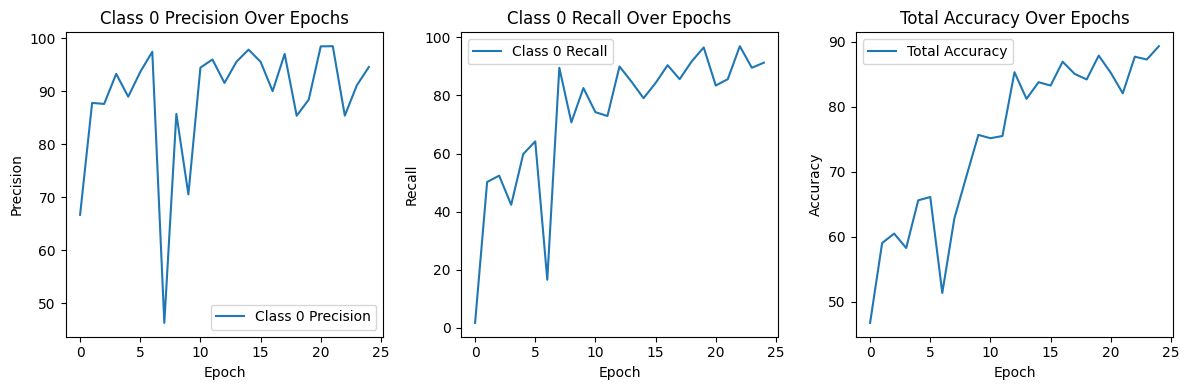

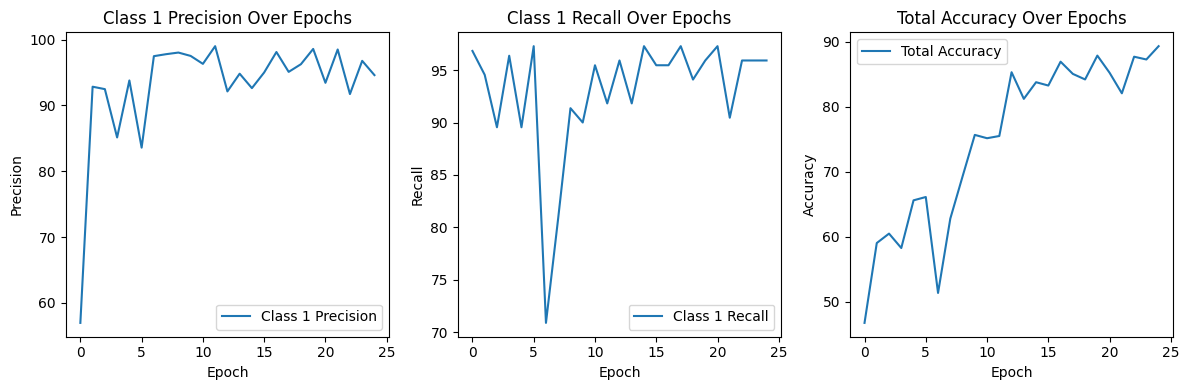

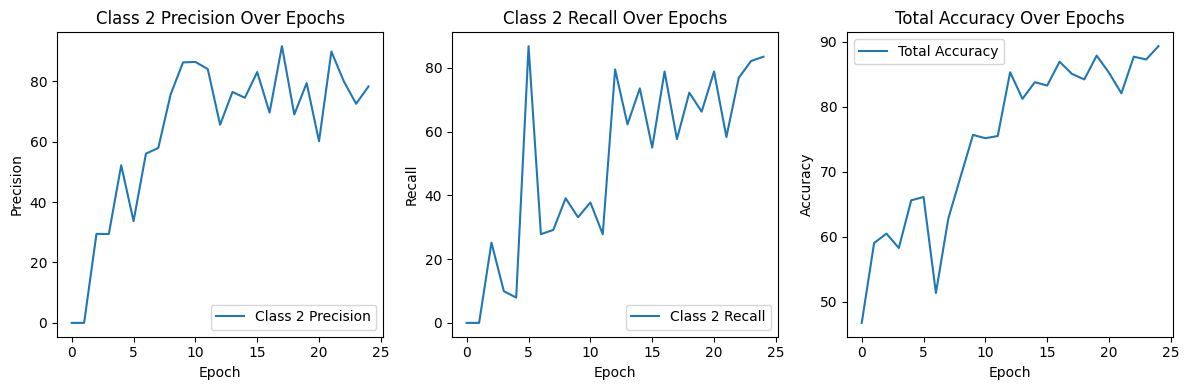

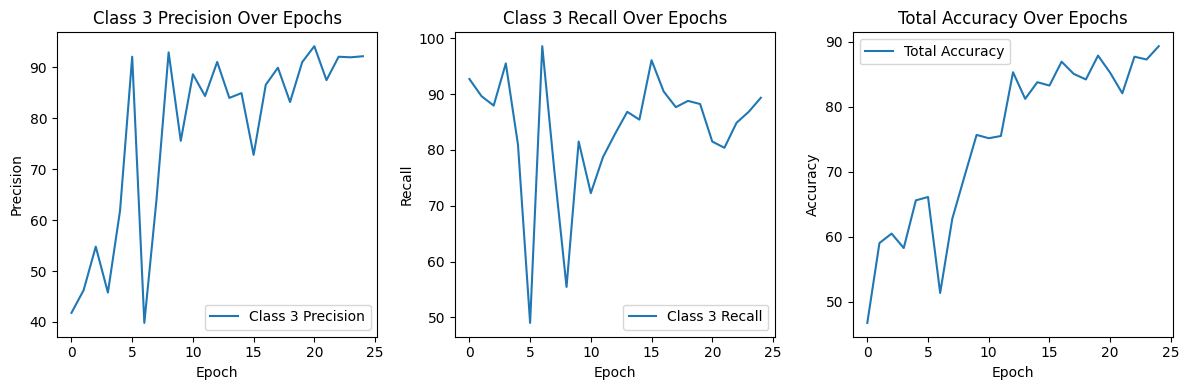

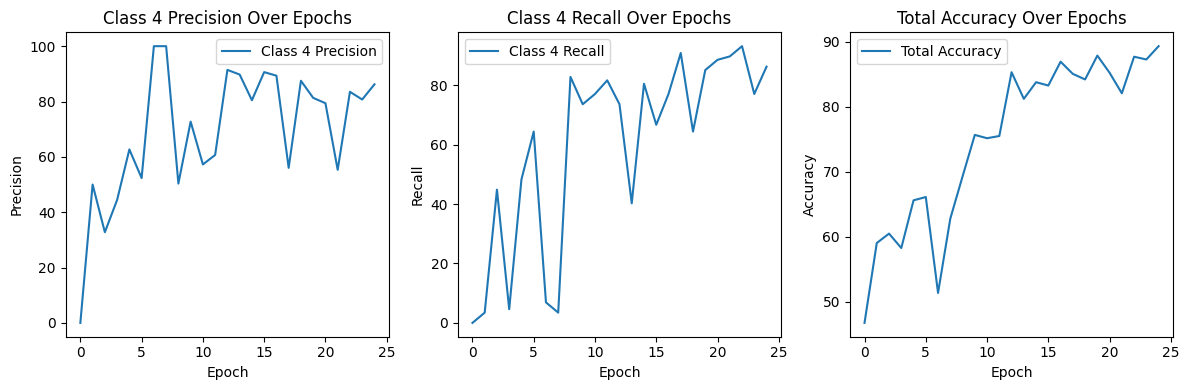

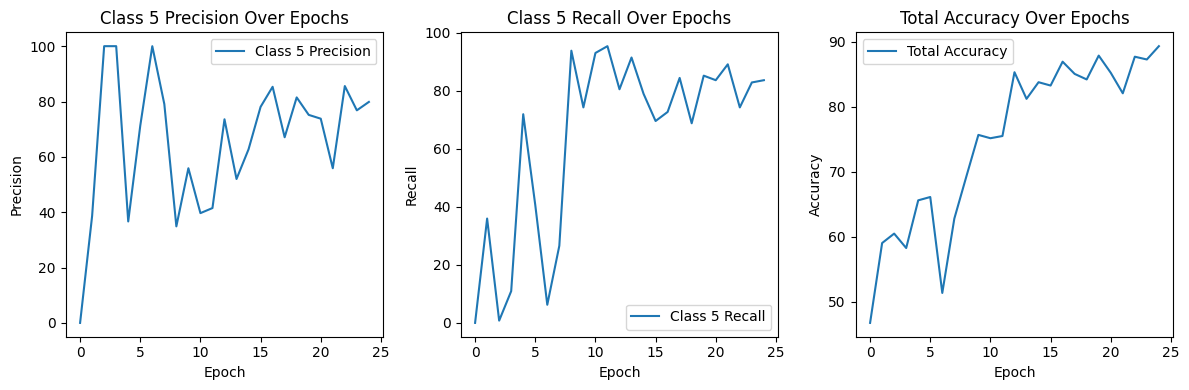

In [24]:
# Plotting the metrics evolution
for i in range(num_classes):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epoch_precision[i], label=f'Class {i} Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title(f'Class {i} Precision Over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epoch_recall[i], label=f'Class {i} Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title(f'Class {i} Recall Over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epoch_accuracy, label='Total Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Total Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Evaluating performances of the two models 

In [4]:
# Parameters
num_classes = 6
batch_size = 16

image_size = 224
csv_file = 'animal_images_test.csv'  # Path to your CSV file

# Data transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Read CSV and prepare dataset
df = pd.read_csv('animal_images_test.csv')

# Convert labels to numerical values and ensure they are integers
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)
# Split the dataset
train_df, val_df = train_test_split(df, test_size=0.2)

# Create dataset objects
test_dataset = AnimalDataset(dataframe=train_df, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [5]:
import torch
import torchvision.models as models
import torch.nn as nn

# Parameters
num_classes = 6
# Load the pre-trained ResNet model
modelc = models.resnet50(pretrained=True)
modelc.fc = nn.Linear(modelc.fc.in_features, num_classes)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelc.to(device)

# Load the saved weights
modelc.load_state_dict(torch.load('animal_classifier_model2.pth', map_location=device))

# Set the model in evaluation mode
modelc.eval()

C:\Users\user1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
# Evaluate the model
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = modelc(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=label_mapping.keys())

# Calculate accuracy per class, total accuracy, precision, and recall
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
total_accuracy = conf_matrix.diagonal().sum() / conf_matrix.sum()
precision_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=0)
recall_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("Accuracy per class:", accuracy_per_class)
print("Total Accuracy:", total_accuracy)
print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

# Display confusion matrix and classification report
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy per class: [0.89373297 0.95800525 0.8359375  0.88801262 0.77941176 0.8377193 ]
Total Accuracy: 0.8826173826173827
Precision per class: [0.93181818 0.96052632 0.76156584 0.92295082 0.8030303  0.77327935]
Recall per class: [0.89373297 0.95800525 0.8359375  0.88801262 0.77941176 0.8377193 ]
Confusion Matrix:
 [[328   2  10  10   4  13]
 [  0 365   3   7   1   5]
 [  4   2 214  17  13   6]
 [ 14   6  32 563   3  16]
 [  1   2   7   4 106  16]
 [  5   3  15   9   5 191]]

Classification Report:
               precision    recall  f1-score   support

      badger       0.93      0.89      0.91       367
        bird       0.96      0.96      0.96       381
         cat       0.76      0.84      0.80       256
         fox       0.92      0.89      0.91       634
       mouse       0.80      0.78      0.79       136
      rabbit       0.77      0.84      0.80       228

    accuracy                           0.88      2002
   macro avg       0.86      0.87      0.86      2002
weighte

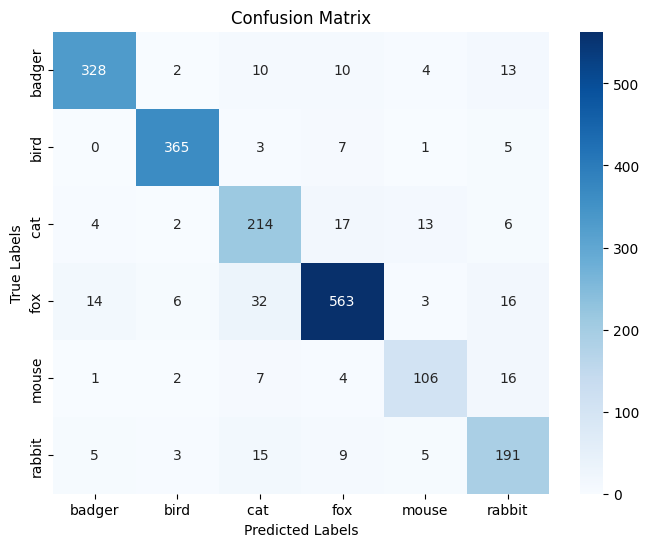

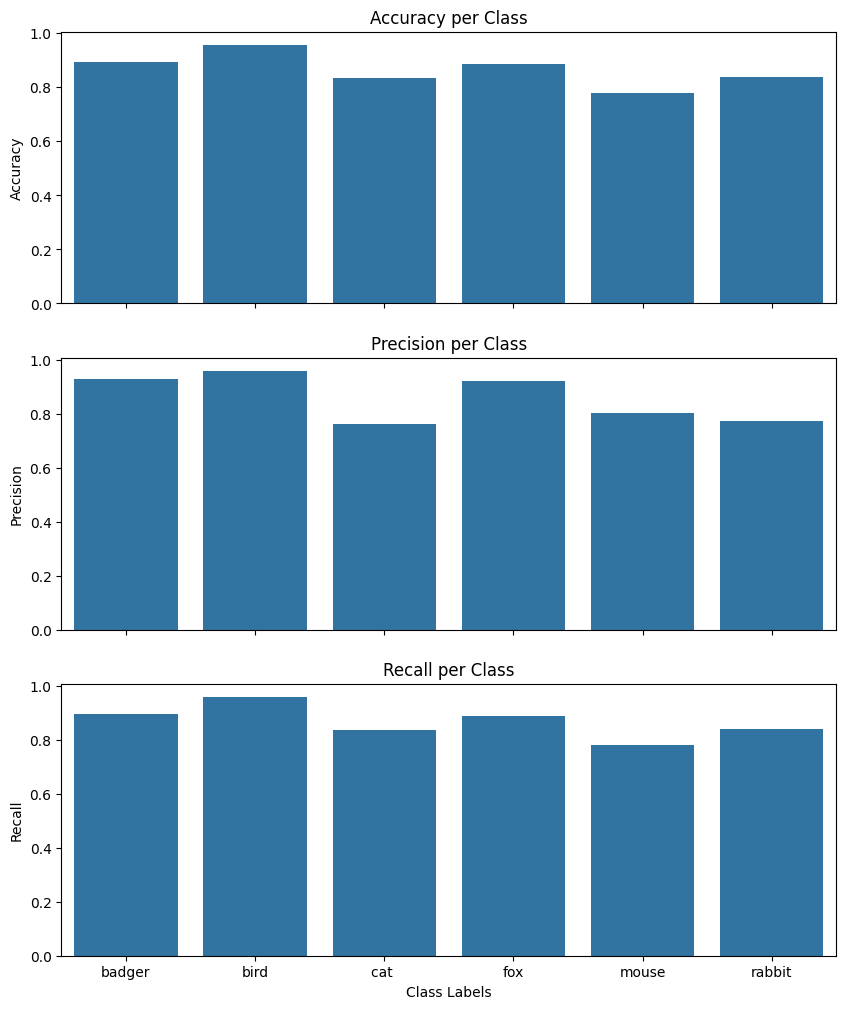

Total Accuracy: 0.8826173826173827

Classification Report:
               precision    recall  f1-score   support

      badger       0.93      0.89      0.91       367
        bird       0.96      0.96      0.96       381
         cat       0.76      0.84      0.80       256
         fox       0.92      0.89      0.91       634
       mouse       0.80      0.78      0.79       136
      rabbit       0.77      0.84      0.80       228

    accuracy                           0.88      2002
   macro avg       0.86      0.87      0.86      2002
weighted avg       0.89      0.88      0.88      2002



In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'label_mapping' is a dictionary mapping class indices to class names
label_mapping = {0: 'badger', 1: 'bird', 2: 'cat ' , 3: 'fox', 4: 'mouse', 5: 'rabbit'}

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Display bar plots for accuracy, precision, and recall per class
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Accuracy per class
sns.barplot(x=label_mapping.values(), y=accuracy_per_class, ax=axes[0])
axes[0].set_title('Accuracy per Class')
axes[0].set_ylabel('Accuracy')

# Precision per class
sns.barplot(x=label_mapping.values(), y=precision_per_class, ax=axes[1])
axes[1].set_title('Precision per Class')
axes[1].set_ylabel('Precision')

# Recall per class
sns.barplot(x=label_mapping.values(), y=recall_per_class, ax=axes[2])
axes[2].set_title('Recall per Class')
axes[2].set_ylabel('Recall')

plt.xlabel('Class Labels')
plt.show()

# Print other metrics
print("Total Accuracy:", total_accuracy)
print("\nClassification Report:\n", class_report)
